<a href="https://colab.research.google.com/github/Bsingh24/CMPE-255/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Authenticating User

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## Loading Data from BigQuery

In [ ]:
%load_ext google.colab.data_table

In [ ]:
!gcloud config set project 'cmpe255hw1-415623'

Updated property [core/project].


In [ ]:
!gcloud config list

[component_manager]
disable_update_check = True
[core]
account = baljot6@gmail.com
project = cmpe255hw1-415623

Your active configuration is: [default]


In [ ]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

In [ ]:
project_id = 'cmpe255hw1-415623'

In [ ]:
client = bigquery.Client(project=project_id)

In [ ]:
q = client.query('''SELECT * FROM `cmpe255hw1-415623.IowaLiquorSales.IowaSales` LIMIT 1000000''')

In [ ]:
df = q.to_dataframe()

## Processing Data for Analysis

In [ ]:
len(df)

992288

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [ ]:
df = df.drop(['date','day', 'invoice_and_item_number', 'store_name', 'store_number', 'address', 'county_number', 'category', 'vendor_number', 'item_number'], axis=1)

In [ ]:
df.head()

In [ ]:
sales = df.copy()

# EDA

## What is the best and worst selling drink?

In [ ]:
val = sales.category_name.value_counts('bottles_sold')
val = sales[['category_name','bottles_sold']].groupby('category_name').sum()
val.sort_values(by=['bottles_sold'], inplace = True, ascending = False)
top10 = val.head(10)
bottom10 = val.tail(10)
top10

,bottles_sold
category_name,
AMERICAN VODKAS,947334
CANADIAN WHISKIES,764440
WHISKEY LIQUEUR,664048
STRAIGHT BOURBON WHISKIES,394114
SPICED RUM,389565
VODKA 80 PROOF,387621
BLENDED WHISKIES,269349
IMPORTED VODKAS,259127
TENNESSEE WHISKIES,201155


<ipython-input-16-c14f82b5aa78>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(top10.index, rotation=90)
<ipython-input-16-c14f82b5aa78>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(bottom10.index, rotation=90)


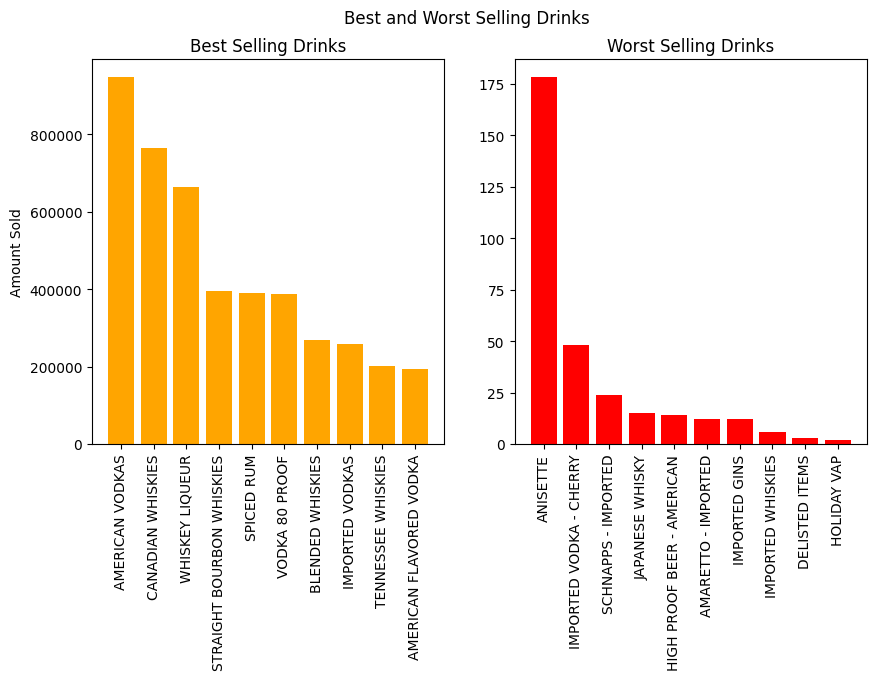

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Best and Worst Selling Drinks')
ax1.bar(top10.index, top10['bottles_sold'], color='orange')
ax1.set_title('Best Selling Drinks')
ax1.set_ylabel('Amount Sold')
ax2.bar(bottom10.index, bottom10['bottles_sold'], color='red')
ax2.set_title('Worst Selling Drinks')
ax1.set_xticklabels(top10.index, rotation=90)
ax2.set_xticklabels(bottom10.index, rotation=90)
fig.show()

The best selling category is the Whiskey Liqueur and worst selling is High Proof American Beer. We will now see what product within those cateogories did the best. This is from 2012 to 2024.


### Best Selling Whiskey Liqueur Statistics

In [ ]:
WHISK = sales[sales['category_name'] == 'AMERICAN VODKAS']

In [ ]:
WHISKSales = WHISK[['item_description','bottles_sold']].groupby('item_description').sum()
WHISKSales.sort_values(by=['bottles_sold'], inplace=True, ascending=False)
topWHISK = WHISKSales.head(10)

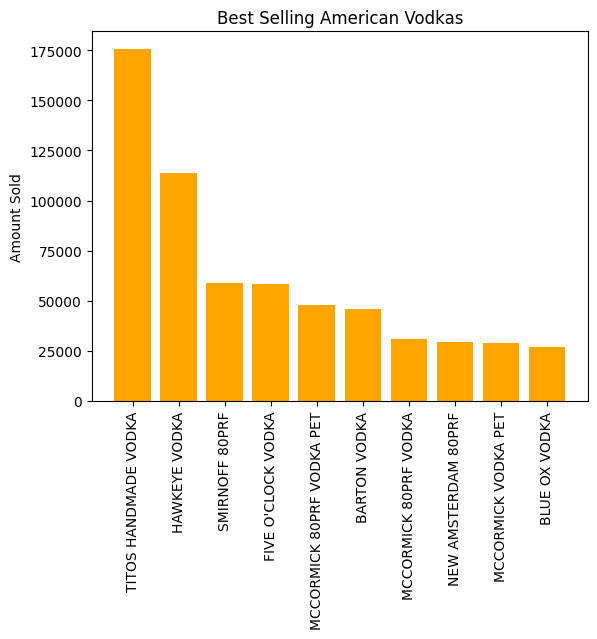

In [ ]:
plt.bar(topWHISK.index, topWHISK['bottles_sold'], color='orange')
plt.title('Best Selling American Vodkas')
plt.ylabel('Amount Sold')
plt.xticks(rotation=90)
plt.show()

Fireball Whiskey is a popular item bought due to its taste, flavor and how well it goes down. Cinnamon aftertaste in itself is comparably more easier to handle than something like vodka. Lets see how it did per year.

In [ ]:
year = sales[sales['item_description'] == 'TITOS HANDMADE VODKA']
year = year[['year','bottles_sold','sale_dollars']].groupby('year').sum()
year.sort_values(by=['year'], inplace=True)
#Remove 2024 so we can the trend
# year.drop(year.tail(1).index,inplace=True)
year

,bottles_sold,sale_dollars
year,,
2012,161,4194.05
2013,791,16467.50
2014,1593,32271.84
2015,2191,44575.53
2016,6323,116191.03
2017,9487,162372.97
2018,15859,297218.42
2019,19311,343173.10
2020,28064,513146.24


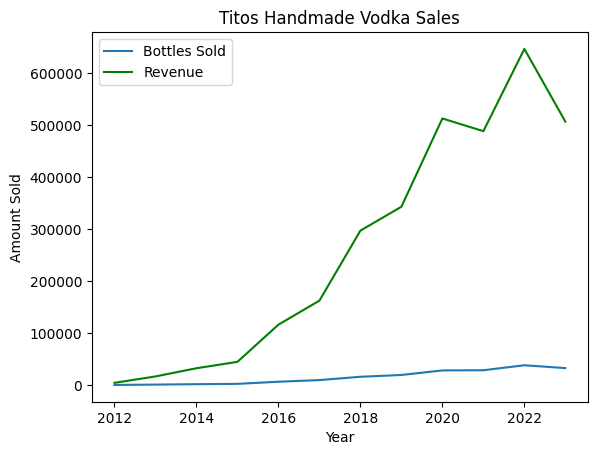

In [ ]:
plt.plot(year.index, year['bottles_sold'])
plt.plot(year.index, year['sale_dollars'], color='green')
plt.title('Titos Handmade Vodka Sales')
plt.xlabel('Year')
plt.ylabel('Amount Sold')
plt.legend(['Bottles Sold', 'Revenue'])
plt.show()

We can definitely see there was an increase in sales after 2015. However, it did drop in 2023 to around 500,000. Based on what the trend is entailing, It is possible 2024 will pass or equal 2023 sales.

### Best Selling Holiday Vap

In [ ]:
sales[sales['category_name'] == 'HOLIDAY VAP']

,city,zip_code,store_location,county,category_name,vendor_name,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,month,year
957803,LEMARS,51031.0,POINT(-96.18335 42.778257),PLYMOUTH,HOLIDAY VAP,DIAGEO AMERICAS,CROWN ROYAL W/2 GLASSES,6,750,15.07,22.61,2,135.66,1.5,0.39,10,2017


Only two bottles were sold in the 2013 so we can assume that Holiday Vap is not as popular with the newer generation or did not have enough sales as a whole.

## Which County/City sold the most? Best seller, worst seller?

In [ ]:
county_sales = sales[['county','bottles_sold']].groupby('county').sum()
county_sales.sort_values(by=['bottles_sold'], inplace=True, ascending=False)
topcounty = county_sales.head(10)
bottomcounty = county_sales.tail(10)

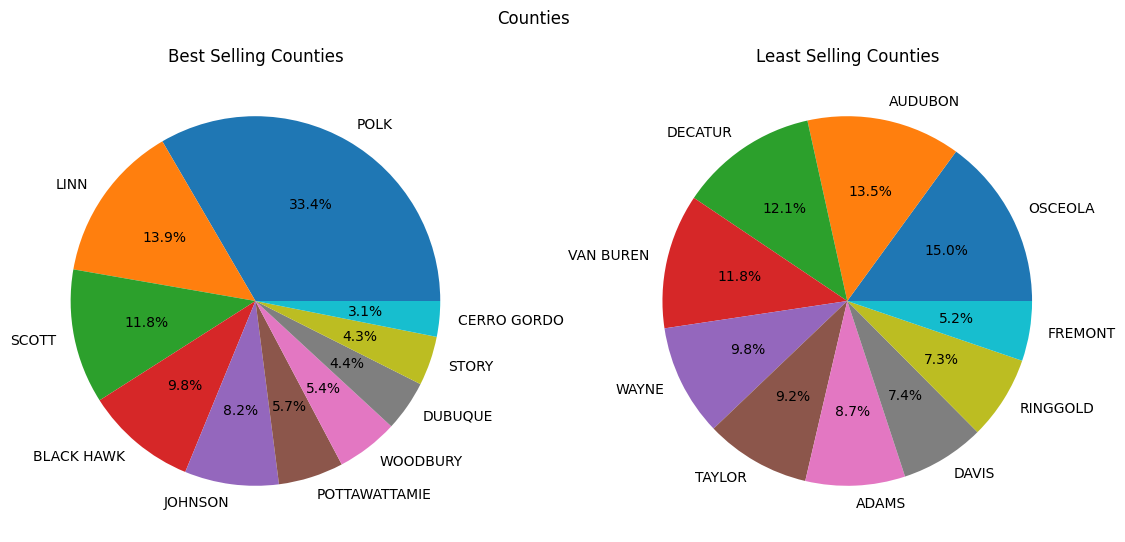

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))
fig.suptitle('Counties')
ax1.pie(topcounty['bottles_sold'], labels=topcounty.index, autopct='%1.1f%%')
ax1.set_title('Best Selling Counties')
ax2.pie(bottomcounty['bottles_sold'], labels=bottomcounty.index, autopct='%1.1f%%')
ax2.set_title('Least Selling Counties')
fig.show()

From this pie chart, we can see the POLK county sold the most bottles while RINGGOLD sold the least. If we look at Polk and Fremont county, we can see there is a big difference between the two. Polk county contains the capital of Iowa Des Moines and Fremont is more rural. The disparity is because of population.

### What city sold the most in Polk

In [ ]:
polk_sales = sales[sales['county'] == 'POLK']
city_sales = polk_sales[['city','bottles_sold', 'sale_dollars']].groupby('city').sum()
city_sales.sort_values(by=['bottles_sold'], inplace=True, ascending=False)
city_sales.head(10)

,bottles_sold,sale_dollars
city,,
DES MOINES,900873,11585298.74
WEST DES MOINES,204686,3025732.64
ANKENY,153557,2418279.39
URBANDALE,100835,1507135.35
WINDSOR HEIGHTS,77207,1227059.14
ALTOONA,65231,906015.15
GRIMES,42351,603665.47
JOHNSTON,39226,533021.45
PLEASANT HILL,32508,417748.74


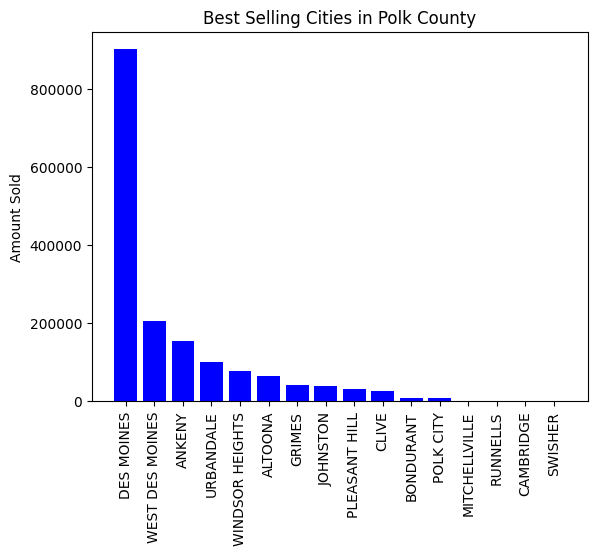

In [ ]:
plt.bar(city_sales.index, city_sales['bottles_sold'], color='blue')
plt.title('Best Selling Cities in Polk County')
plt.ylabel('Amount Sold')
plt.xticks(rotation=90)
plt.show()

We can see Des Moines sells the most liquor and this aligns with it being the capital of Iowa.

## Were there any liquor categories that dropped in or increased in sales over the years?

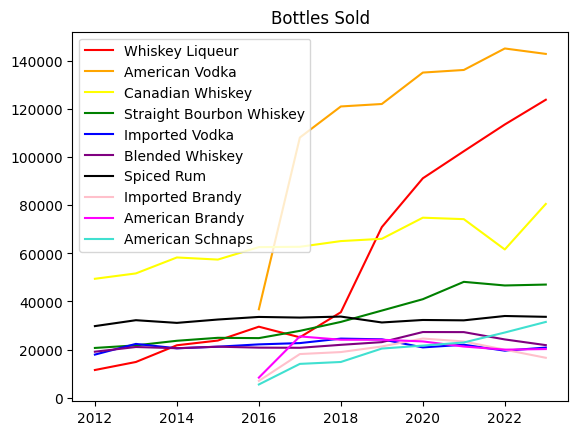

In [ ]:
# WHISKEY LIQUEUR
# AMERICAN VODKAS
# CANADIAN WHISKIES
# STRAIGHT BOURBON WHISKIES
# IMPORTED VODKAS
# BLENDED WHISKIES
# SPICED RUM
# IMPORTED BRANDIES
# AMERICAN BRANDIES
# AMERICAN SCHNAPPS
sales = sales[sales.year != 2024]


WL = sales[sales['category_name'] == 'WHISKEY LIQUEUR']
WL = WL[['bottles_sold','year','sale_dollars']].groupby('year').sum()
AV = sales[sales['category_name'] == 'AMERICAN VODKAS']
AV = AV[['bottles_sold','year','sale_dollars']].groupby('year').sum()
CW = sales[sales['category_name'] == 'CANADIAN WHISKIES']
CW = CW[['bottles_sold','year','sale_dollars']].groupby('year').sum()
SWB = sales[sales['category_name'] == 'STRAIGHT BOURBON WHISKIES']
SWB = SWB[['bottles_sold','year','sale_dollars']].groupby('year').sum()
IV = sales[sales['category_name'] == 'IMPORTED VODKAS']
IV = IV[['bottles_sold','year','sale_dollars']].groupby('year').sum()
BW = sales[sales['category_name'] == 'BLENDED WHISKIES']
BW = BW[['bottles_sold','year','sale_dollars']].groupby('year').sum()
SR = sales[sales['category_name'] == 'SPICED RUM']
SR = SR[['bottles_sold','year','sale_dollars']].groupby('year').sum()
IB = sales[sales['category_name'] == 'IMPORTED BRANDIES']
IB = IB[['bottles_sold','year','sale_dollars']].groupby('year').sum()
AB = sales[sales['category_name'] == 'AMERICAN BRANDIES']
AB = AB[['bottles_sold','year','sale_dollars']].groupby('year').sum()
AS = sales[sales['category_name'] == 'AMERICAN SCHNAPPS']
AS = AS[['bottles_sold','year','sale_dollars']].groupby('year').sum()

liquor = [WL, AV, CW, SWB, IV, BW, SR, IB, AB, AS]
color = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'black', 'pink', 'magenta', 'turquoise']

for i in range(len(liquor)):
    plt.plot(liquor[i].index, liquor[i]['bottles_sold'], color=color[i])

plt.legend(['Whiskey Liqueur', 'American Vodka', 'Canadian Whiskey', 'Straight Bourbon Whiskey', 'Imported Vodka', 'Blended Whiskey', 'Spiced Rum', 'Imported Brandy', 'American Brandy', 'American Schnaps'])
plt.title('Bottles Sold')
plt.show()

We can note Whiskey Liqueur, American Vodka and Straight Bourbon Whiskey all increased bit the rest stayed relatively the same over the past decade. This does not mean they are necessarily since non of them dipped severely.

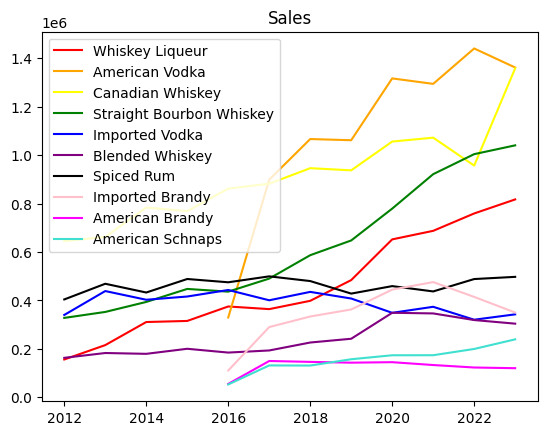

In [ ]:
for i in range(len(liquor)):
    plt.plot(liquor[i].index, liquor[i]['sale_dollars'], color=color[i])

plt.legend(['Whiskey Liqueur', 'American Vodka', 'Canadian Whiskey', 'Straight Bourbon Whiskey', 'Imported Vodka', 'Blended Whiskey', 'Spiced Rum', 'Imported Brandy', 'American Brandy', 'American Schnaps'])
plt.title('Sales')
plt.show()

Sales overall went up for the majority of these categories even though some of these categories sold the same amount of bottles over the past decade.

## Has the average price of a bottle changed over the years?

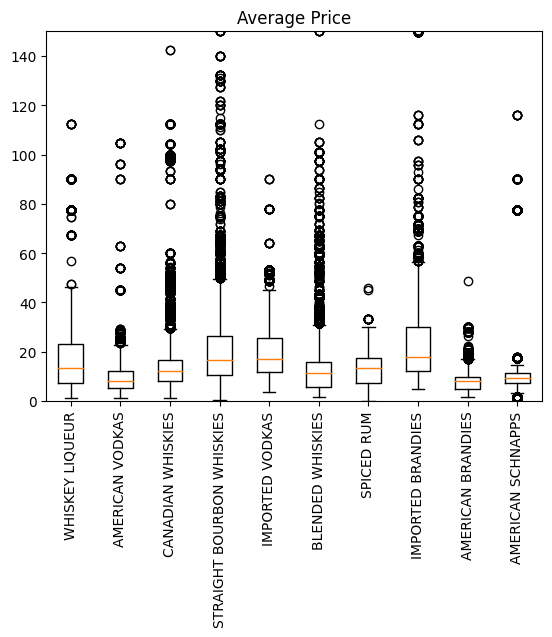

In [ ]:
WL = sales[sales['category_name'] == 'WHISKEY LIQUEUR']
AV = sales[sales['category_name'] == 'AMERICAN VODKAS']
CW = sales[sales['category_name'] == 'CANADIAN WHISKIES']
SWB = sales[sales['category_name'] == 'STRAIGHT BOURBON WHISKIES']
IV = sales[sales['category_name'] == 'IMPORTED VODKAS']
BW = sales[sales['category_name'] == 'BLENDED WHISKIES']
SR = sales[sales['category_name'] == 'SPICED RUM']
IB = sales[sales['category_name'] == 'IMPORTED BRANDIES']
AB = sales[sales['category_name'] == 'AMERICAN BRANDIES']
AS = sales[sales['category_name'] == 'AMERICAN SCHNAPPS']


Average = {'WHISKEY LIQUEUR': WL['state_bottle_retail'], 'AMERICAN VODKAS': AV['state_bottle_retail'], 'CANADIAN WHISKIES' : CW['state_bottle_retail'], 'STRAIGHT BOURBON WHISKIES' : SWB['state_bottle_retail']
           , 'IMPORTED VODKAS' : IV['state_bottle_retail'], 'BLENDED WHISKIES' : BW['state_bottle_retail'], 'SPICED RUM' : SR['state_bottle_retail'], 'IMPORTED BRANDIES' : IB['state_bottle_retail']
           , 'AMERICAN BRANDIES' : AB['state_bottle_retail'], 'AMERICAN SCHNAPPS' : AS['state_bottle_retail']}

plt.boxplot(Average.values(), labels=Average.keys())
plt.title('Average Price')
plt.ylim(0,150)
plt.xticks(rotation=90)
plt.show()

There are a lot of outliers within this dataset but the average stays relatively below 40 dollars. Lets look closer at how much something like American Vodkas has changed in price over the years.

In [ ]:
AV['year']

33        2023
34        2023
35        2023
36        2023
37        2023
          ... 
991897    2016
991900    2018
992151    2018
992152    2016
992154    2017
Name: year, Length: 77792, dtype: Int64

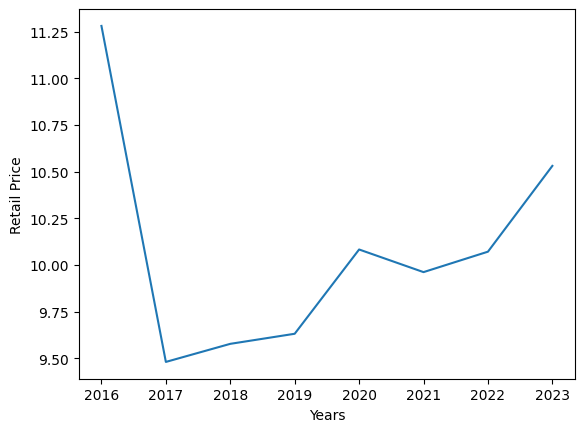

In [ ]:
AV_sales = AV[['year', 'state_bottle_retail']].groupby('year').mean()
plt.plot(AV_sales.index, AV_sales['state_bottle_retail'])
plt.xlabel('Years')
plt.ylabel('Retail Price')
plt.show()

We can definitely see the price of American Vodkas decreased but increased in 2017 this could be true for all other categories as inflation can play a big role as to why things cost more.

### Average Retail Price of the top 10 Categories Over the Years

In [ ]:
WL = WL[['state_bottle_retail','year', 'state_bottle_cost', 'pack', 'bottle_volume_ml']].groupby('year').mean()
AV = AV[['state_bottle_retail','year', 'state_bottle_cost', 'pack', 'bottle_volume_ml']].groupby('year').mean()
CW = CW[['state_bottle_retail','year', 'state_bottle_cost', 'pack', 'bottle_volume_ml']].groupby('year').mean()
SWB = SWB[['state_bottle_retail','year', 'state_bottle_cost', 'pack', 'bottle_volume_ml']].groupby('year').mean()
IV = IV[['state_bottle_retail','year', 'state_bottle_cost', 'pack', 'bottle_volume_ml']].groupby('year').mean()
BW = BW[['state_bottle_retail','year', 'state_bottle_cost', 'pack', 'bottle_volume_ml']].groupby('year').mean()
SR = SR[['state_bottle_retail','year', 'state_bottle_cost', 'pack', 'bottle_volume_ml']].groupby('year').mean()
IB = IB[['state_bottle_retail','year', 'state_bottle_cost', 'pack', 'bottle_volume_ml']].groupby('year').mean()
AB = AB[['state_bottle_retail','year', 'state_bottle_cost', 'pack', 'bottle_volume_ml']].groupby('year').mean()
AS = AS[['state_bottle_retail','year', 'state_bottle_cost', 'pack', 'bottle_volume_ml']].groupby('year').mean()

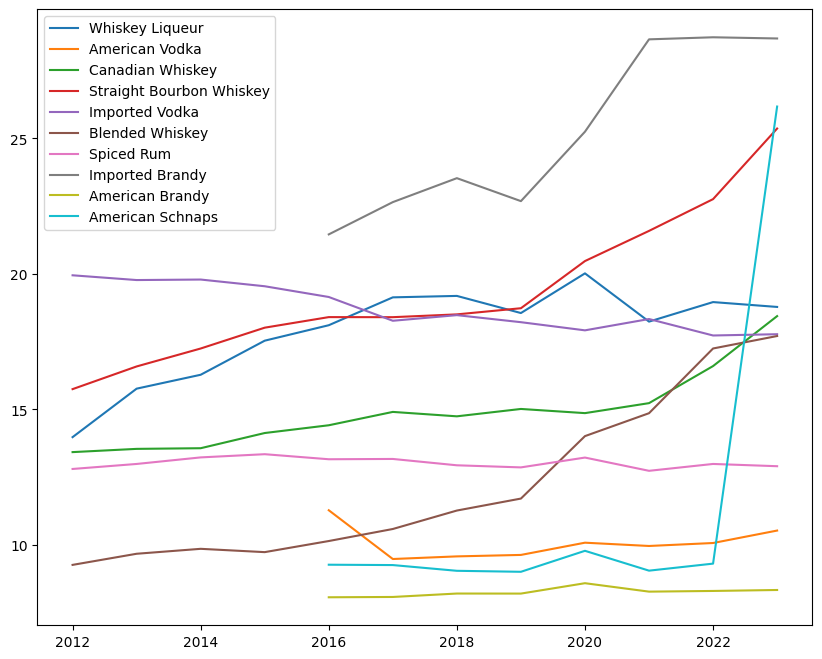

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(WL.index, WL['state_bottle_retail'])
plt.plot(AV.index, AV['state_bottle_retail'])
plt.plot(CW.index, CW['state_bottle_retail'])
plt.plot(SWB.index, SWB['state_bottle_retail'])
plt.plot(IV.index, IV['state_bottle_retail'])
plt.plot(BW.index, BW['state_bottle_retail'])
plt.plot(SR.index, SR['state_bottle_retail'])
plt.plot(IB.index, IB['state_bottle_retail'])
plt.plot(AB.index, AB['state_bottle_retail'])
plt.plot(AS.index, AS['state_bottle_retail'])
plt.legend(['Whiskey Liqueur', 'American Vodka', 'Canadian Whiskey', 'Straight Bourbon Whiskey', 'Imported Vodka', 'Blended Whiskey', 'Spiced Rum', 'Imported Brandy', 'American Brandy', 'American Schnaps'])
plt.show()

Price has overall stayed the same over the years except for a few categories where it went up after 2020.

## What vendor is the majority? (Provides the most liquor)

In [ ]:
vendor = sales[['vendor_name','pack', 'bottles_sold']].groupby('vendor_name').sum()
vendor.sort_values(by=['bottles_sold'], inplace=True, ascending=False)
vendor_bottles = vendor.head(10)
vendor.sort_values(by=['pack'], inplace=True, ascending=False)
vendor_provide = vendor.head(10)

In [ ]:
vendor_bottles.index

Index(['DIAGEO AMERICAS', 'SAZERAC COMPANY  INC', 'JIM BEAM BRANDS',
       'HEAVEN HILL BRANDS', 'LUXCO INC', 'SAZERAC NORTH AMERICA',
       'PERNOD RICARD USA', 'LUXCO-ST LOUIS', 'PROXIMO',
       'CONSTELLATION WINE COMPANY, INC.'],
      dtype='object', name='vendor_name')

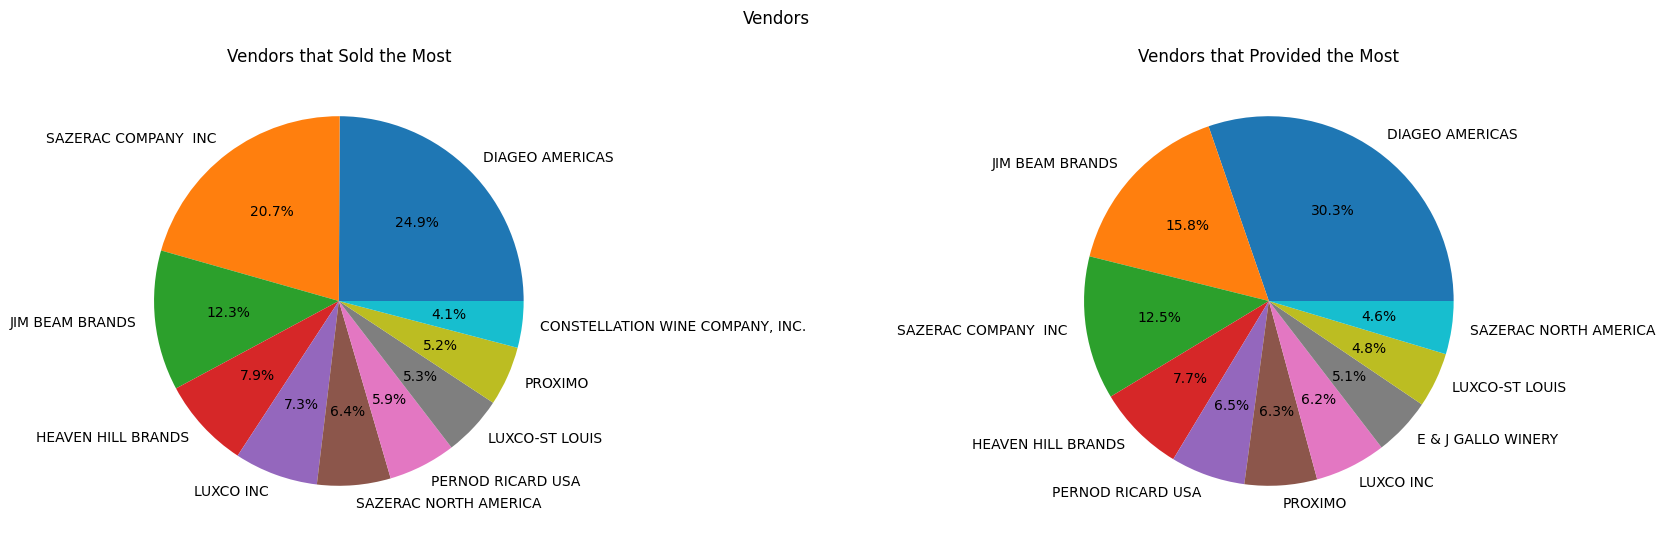

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(22,6))
fig.suptitle('Vendors')
ax1.pie(vendor_bottles['bottles_sold'], labels=vendor_bottles.index, autopct='%1.1f%%')
ax1.set_title('Vendors that Sold the Most')
ax2.pie(vendor_provide['pack'], labels=vendor_provide.index, autopct='%1.1f%%')
ax2.set_title('Vendors that Provided the Most')
fig.show()

We can see Diageo Americas sold and provided the most liquor in Iowa. Sazerac Company Inc sold the 2nd most but did not provide the second most. It is almost tied with Jim Bean Brands.

### What products does Diageo Americas Sell

In [ ]:
DIAGEO = sales[sales['vendor_name'] == 'DIAGEO AMERICAS']
DIAGEO = DIAGEO[['category_name']].groupby('category_name').sum()
DIAGEO

""
category_name
100 PROOF VODKA
100% AGAVE TEQUILA
AGED DARK RUM
AMERICAN COCKTAILS
AMERICAN DRY GINS
AMERICAN FLAVORED VODKA
AMERICAN SCHNAPPS
AMERICAN VODKAS
BLENDED WHISKIES


Seems like Diageo sells a variety of drinks rather than just one type of drink. This could be true for the rest of the vendors.

# Conclusion & Saving Updated Dataset to BigQuery

Based on this dataset, we have learned the overall sales have increased dramatically over the decade with Fireball Cinnamon Whiskey being the best seller. Not many of the popular drinks grew or dropped in popularity except for a few like Whiskey. The average price of a bottle seems to be below 40 dollars but there are several options way above that price point as well as below. Price has also increased overtime due to factors like inflation but have dropped because of COVID since some manufacturers were forced to close for a few months. The same goes for small businesses selling these products. Overall, it seems that 2024 will be a good year for liquor sales as it has no intention of slowing down.

In [ ]:
sales.to_gbq('cmpe255hw1-415623.IowaLiquorSales.IowaSales', project_id= 'cmpe255hw1-415623', if_exists='replace', progress_bar=True)

100%|██████████| 1/1 [00:00<00:00, 5769.33it/s]
